In [1]:
import os, sys
from tqdm import trange

import math
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy

import torch
from torch import nn

source = "/home/loek/projects/rnn/source"
sys.path.append(source)

from data import fun_data, grid_data
from preprocessing import Direct
from compilation import Compiler, Tracker, ScalarTracker, ActivationTracker
from data_analysis.automata import to_automaton_history
from data_analysis.visualization.animation import SliderAnimation
from data_analysis.visualization.activations import (
    ActivationsAnimation,
    FunctionAnimation,
)
from data_analysis.visualization.automata import AutomatonAnimation
from data_analysis.visualization.epochs import EpochAnimation

from model import Model

import cProfile
import pstats


is_cuda = torch.cuda.is_available()
if is_cuda:
    device = torch.device("cuda")
    print("GPU available")
else:
    device = torch.device("cpu")
    print("GPU not available")

device = torch.device("cpu")

GPU available


In [2]:
diff = 1
compl = 5
gain = 1
n_datapoints = 2

In [3]:
## Generate data
function = lambda x: diff * np.sin(compl * x) + 1
# function = lambda x: np.sin(x)
bounds = [-3, 3]

train_datasets = [
    fun_data(device, function, bounds=bounds, n_datapoints=n_datapoints),
]
val_dataset = [fun_data(device, function, bounds=bounds, n_datapoints=100)]

tracked_datasets = val_dataset + train_datasets

encoding = Direct()

In [4]:
## Instantiate model
model = Model(
    encoding=encoding,
    input_size=1,
    output_size=1,
    hidden_dim=50,
    n_hid_layers=30,
    device=device,
    init_std=gain,
)

In [5]:
## Setup compiler

# Define hyperparameters
n_epochs = 2000
lr = 0.001

# Define Loss, Optimizer
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)
compiler = Compiler(model, criterion, optimizer)
compiler.trackers = {
    "loss": ScalarTracker(lambda: compiler.validation(tracked_datasets)),
    "hidden": ActivationTracker(
        model, lambda inputs: model(inputs)[1][int(len(model) / 2)]
    ),
    "output": ActivationTracker(model, lambda inputs: model(inputs)[0]),
}

In [6]:
## Training run
compiler.training_run(
    train_datasets, tracked_datasets, n_epochs=n_epochs, batch_size=1000
)

Training:  13%|█▎        | 259/2000 [00:07<00:52, 33.45steps/s, train_loss=0.00000, val_loss=0.71194]


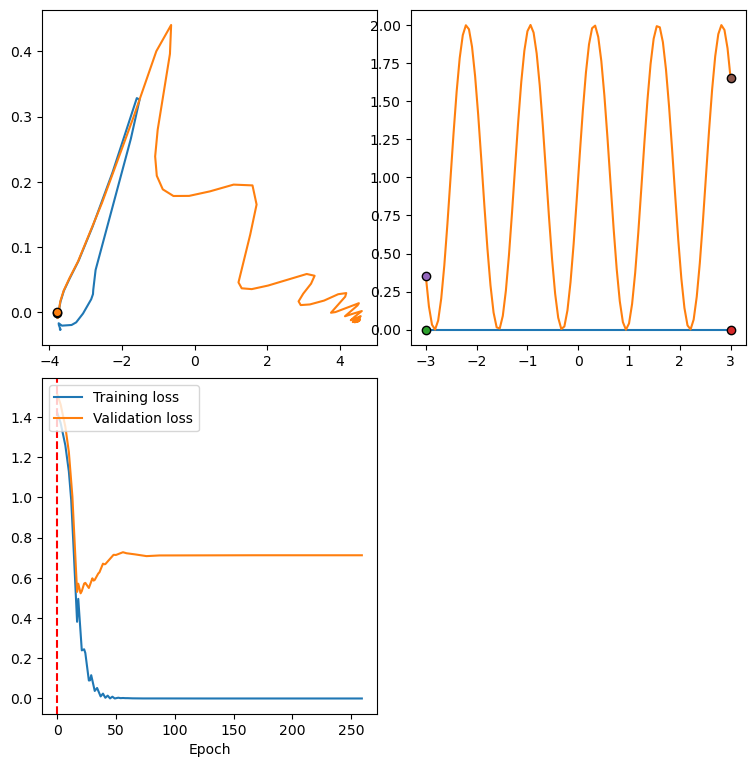

interactive(children=(IntSlider(value=0, description='Epoch:', layout=Layout(width='39%'), max=259), Output())…

In [7]:
## Visualize representation dynamics
data_hid = compiler.trackers["hidden"].get_trace()
data_output = compiler.trackers["output"].get_trace()
query = "Epoch >= 0"
data_hid = data_hid.query(query).copy()
data_output = data_output.query(query).copy()

loss = compiler.trackers["loss"].get_trace()
val_loss = loss.query("Dataset==0")[0].to_numpy()
train_loss = loss.query("Dataset>0").groupby("Epoch").mean()

# weight_change = compiler.trackers["weight change"].get_trace().to_numpy().reshape(-1)

animation = SliderAnimation(
    [
        ActivationsAnimation(
            data_hid.query("Dataset != 0"), transform="PCA", plot_labels=False
        ),
        FunctionAnimation(
            data_output.query("Dataset != 0"),
            data_output.query("Dataset == 0"),
            true_function=function,
        ),
        EpochAnimation(
            graphs={
                "Training loss": train_loss,
                "Validation loss": val_loss,
            },
            unitless_graphs={
                # "weight change": weight_change,
            },
            # x_bounds=(0, 800),
            # y_bounds=(0, 1),
        ),
    ],
    parameters=list(set(data_hid.index.get_level_values("Epoch"))),
    fig_size=4,
)


# TODO Plot map A(h)
# TODO Plot pairwise distances
# TODO Plot total theta

In [ ]:
name = f"compl{compl}gain{gain}"
# animation.to_gif("plots/" + name, step_size=int(len(train_loss) / 1000))